<a href="https://colab.research.google.com/github/pekgnee/ACV_Quickdraw_challenge_with_TPU/blob/master/ACV_Quickdraw_challenge_with_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quickdraw

In [2]:
!wget -qq https://www.dropbox.com/s/gdlb8dnjzcly51o/quickdraw.zip
  
!unzip -qq quickdraw.zip

!rm -r __MACOSX
!rm quickdraw.zip

!ls

quickdraw  sample_data


In [3]:
!ls quickdraw

'alarm clock.npy'   bee.npy		 cookie.npy	  lollipop.npy
 ambulance.npy	   'birthday cake.npy'	 donut.npy	 'palm tree.npy'
 angel.npy	    brain.npy		 eyeglasses.npy   pig.npy
 ant.npy	    cactus.npy		 face.npy	  postcard.npy
 banana.npy	    cat.npy		 fish.npy	  rainbow.npy


## Imports

In [4]:
import os
try:
    device_name = os.environ['COLAB_TPU_ADDR']
    TPU_ADDRESS = 'grpc://' + device_name
    print('Found TPU at: {}'.format(TPU_ADDRESS))

except KeyError:
    print('TPU not found')

Found TPU at: grpc://10.109.116.34:8470


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

from glob import glob
import ntpath

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import tensorflow as tf

In [6]:
arr = np.load('./quickdraw/bee.npy')
arr.shape

(120890, 784)

In [0]:
file_names = glob('./quickdraw/*.npy')

In [8]:
# make some class names
class_names = []

for file in file_names:
  name = ntpath.basename(file)
  class_names.append(name[:-4])
  
  
print(class_names)

['angel', 'alarm clock', 'lollipop', 'cat', 'donut', 'palm tree', 'fish', 'brain', 'postcard', 'bee', 'pig', 'banana', 'face', 'birthday cake', 'cactus', 'cookie', 'rainbow', 'ant', 'ambulance', 'eyeglasses']


In [0]:
# get 200 of each class for plotting

x_data =np.array([])
y_labels =np.array([])

for i, filename in enumerate(file_names):
  labels = [i for j in range(200)]
  arr = np.load(filename)
  arr = arr[:200]
  if len(x_data) == 0:
    x_data = arr
    y_labels = np.asarray(labels)
  else:
    x_data = np.concatenate((x_data, arr))
    y_labels = np.concatenate((y_labels, labels))

In [10]:
y_labels.shape

(4000,)

In [11]:
y_labels[190:210]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## For MNIST

In [12]:
(mnist_x,mnist_y), (_,_) = tf.keras.datasets.mnist.load_data()
mnist_x =mnist_x.reshape(60000,784)

11493376/11490434 [==============================] - 0s 0us/step


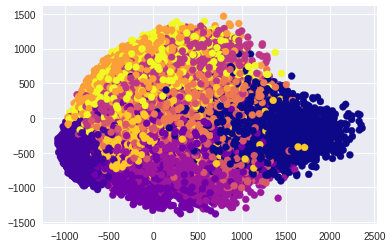

In [13]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(mnist_x)
groups = mnist_y.tolist()
colors = [int(i % 20) for i in groups]

plt.scatter(principalComponents[:,0], principalComponents[:,1], c=colors,cmap=plt.cm.plasma)
plt.show()

## PCA for QuickDraw

(2000, 2)


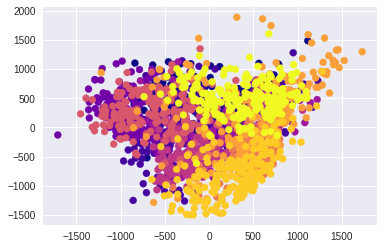

In [14]:
# from sklearn.preprocessing import StandardScaler
# x = StandardScaler().fit_transform(x_data)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_data[:2000])

print(principalComponents.shape)

groups = y_labels.tolist()
colors = [int(i % 20) for i in groups[:2000]]

plt.scatter(principalComponents[:,0], principalComponents[:,1], c=colors,cmap=plt.cm.plasma)
plt.show()

## Plot TSNE  for QuickDraw

In [15]:
import time

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x_data[:2000])

print('t-SNE Finished! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.084s...
[t-SNE] Computed neighbors for 2000 samples in 9.194s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 624.277157
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.959473
[t-SNE] KL divergence after 300 iterations: 1.875906
t-SNE Finished! Time elapsed: 19.279719352722168 seconds


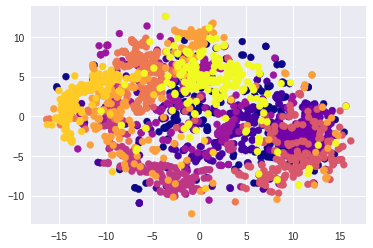

In [16]:
import matplotlib.cm as cm

groups = y_labels.tolist()

colors = [int(i % 20) for i in groups[:2000]]

plt.scatter(tsne_results[:,0], tsne_results[:,1], c=colors,cmap=plt.cm.plasma)
plt.show()

In [0]:
# get 10000 of each class for the model

FILES_PER_CLASS = 10000
x_data =np.array([])
y_labels =np.array([])

for i, filename in enumerate(file_names):
  labels = [i for j in range(FILES_PER_CLASS)]
  arr = np.load(filename)
  arr = arr[:FILES_PER_CLASS]
  if len(x_data) == 0:
    x_data = arr
    y_labels = np.asarray(labels)
  else:
    x_data = np.concatenate((x_data, arr))
    y_labels = np.concatenate((y_labels, labels))

## Prepare data for network

In [0]:
# shuffle before splitting to training and validation
from sklearn.utils import shuffle
x_data, y_labels = shuffle(x_data, y_labels, random_state=42)

# splitting data files between training and validation
VALIDATION_SPLIT = 0.2
split = int(len(x_data) * VALIDATION_SPLIT)
x_train = x_data[split:]
x_test = x_data[:split]

y_train = y_labels[split:]
y_test = y_labels[:split]

In [0]:
image_size = 28

# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = tf.keras.utils.to_categorical(y_train, len(class_names))
y_test = tf.keras.utils.to_categorical(y_test, len(class_names))

In [20]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)
print(y_train.shape[0], 'train labels')

x_train shape: (160000, 28, 28, 1)
160000 train samples
40000 test samples
y_train shape: (160000, 20)
160000 train labels


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

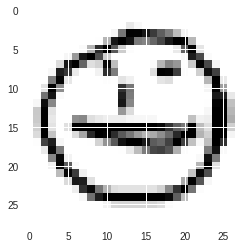

In [21]:
import random

rand_idx = random.randint(0, x_train.shape[0]-1)
plt.imshow(x_train[rand_idx].reshape((28, 28)))
y_train[rand_idx]

## Data Pipeline

In [0]:
# Resnet needs 3 channels
def one_to_three(image, label):
  image = tf.image.grayscale_to_rgb(image)
  return image, label

In [0]:
def train_input_fn(batch_size=1024):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.cache()
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.map(one_to_three)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size, drop_remainder=True)


    # Return the dataset.
    return dataset

In [0]:
def test_input_fn(batch_size=1024):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.cache()
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.map(one_to_three)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size, drop_remainder=True)


    # Return the dataset.
    return dataset

# ResNet50 Model from scratch rather than premade model

In [0]:
import tensorflow.keras.layers as layers
from tensorflow.python.keras.models import Model

In [0]:
# use tf data (copy from from JS04-06 Transfer Learning - cats and dogs.ipynb)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.repeat(100)
train_dataset = train_dataset.batch(32)

valid_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
valid_dataset = valid_dataset.repeat(100)
valid_dataset = valid_dataset.batch(32)


In [0]:
# use tf data (copy from from JS04-06 Transfer Learning - cats and dogs.ipynb)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.repeat(100)
train_dataset = train_dataset.batch(32)

valid_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
valid_dataset = valid_dataset.repeat(100)
valid_dataset = valid_dataset.batch(32)


In [0]:
learning_rate = 0.01
batch_size = 128

## The 2 main blocks for ResNet50 - Identity Block & ConvBlock

In [0]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    bn_axis = 3

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

In [0]:
def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the first conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
    filters1, filters2, filters3 = filters
    bn_axis = 3
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [31]:
weights = None#'imagenet'

input_shape = (image_size,image_size,3)
pooling = 'avg'
bn_axis = 3

include_top = False
classes = len(file_names)

Inp = tf.keras.Input(
      name='input', shape=input_shape, batch_size=batch_size, dtype=tf.float32)
# Inp = layers.Input(shape=batch_size,input_shape)

x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(Inp)
x = layers.Conv2D(64, (7, 7),
                  strides=(2, 2),
                  padding='valid',
                  kernel_initializer='he_normal',
                  name='conv1')(x)

x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
x = layers.Activation('relu')(x)
x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

if include_top:
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    output = layers.Dense(classes, activation='softmax', name='fc1000')(x)
else:
    if pooling == 'avg':
        x = layers.GlobalAveragePooling2D()(x)
    elif pooling == 'max':
        x = layers.GlobalMaxPooling2D()(x)
    else:
        warnings.warn('The output shape of `ResNet50(include_top=False)` '
                      'has been changed since Keras 2.2.0.')

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
base_model = Model(Inp, x, name='resnet50')

In [0]:
WEIGHTS_PATH = ('https://github.com/fchollet/deep-learning-models/'
                'releases/download/v0.2/'
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5')

WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.2/'
                       'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [0]:
# Load weights.
if weights == 'imagenet':
    if include_top:
        weights_path = tf.keras.utils.get_file(
            'resnet50_weights_tf_dim_ordering_tf_kernels.h5',
            WEIGHTS_PATH,
            cache_subdir='models',
            md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
    else:
        weights_path = keras_utils.get_file(
            'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
            WEIGHTS_PATH_NO_TOP,
            cache_subdir='models',
            md5_hash='a268eb855778b3df3c7506639542a6af')
    base_model.load_weights(weights_path)
elif weights is not None:
    base_model.load_weights(weights)

In [35]:
# add a global spatial average pooling layer
x = base_model.output

# let's add a fully-connected layer
x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.3)(x)

# and a logits layer -- let's say we have 2 classes
predictions = layers.Dense(classes, activation='softmax')(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Create model.
model = Model(Inp, predictions, name='full')

In [37]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (128, 28, 28, 3)     0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (128, 34, 34, 3)     0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (128, 14, 14, 64)    9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (128, 14, 14, 64)    256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Compile the model

In [0]:
# Use a tf optimizer rather than a Keras one for now
opt = tf.train.AdamOptimizer(learning_rate)

model.compile(
      optimizer=opt,
      loss='categorical_crossentropy',
      metrics=['acc'])

In [39]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.109.116.34:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 1954655293754624075)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 10472206779812963682)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 4077516938139973509)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:

In [40]:
tpu_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (128, 28, 28, 3)     0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (128, 34, 34, 3)     0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (128, 14, 14, 64)    9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (128, 14, 14, 64)    256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Train

In [41]:
# need to freeze weights in base model
train_steps = int(x_train.shape[0]/batch_size)
valid_steps = int(x_test.shape[0]/batch_size)


print('train steps:',train_steps)
print('valid steps:',valid_steps)

train steps: 1250
valid steps: 312


In [42]:

tpu_model.fit(
    train_input_fn,
    steps_per_epoch = train_steps,
    epochs=10,
    validation_data = test_input_fn,
    validation_steps = valid_steps

)

Epoch 1/10
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(1024,), dtype=tf.int32, name=None), TensorSpec(shape=(1024, 28, 28, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1024, 20), dtype=tf.float32, name=None)]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 55.20539140701294 secs
INFO:tensorflow:Setting weights on TPU model.
1249/1250 [============================>.] - ETA: 0s - loss: 0.5574 - acc: 0.8394INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(1024,), dtype=tf.int32, name=None), TensorSpec(shape=(1024, 28, 28, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1024, 20), dtype=tf.float32, name=None)]
INFO:tensorflow:Overriding default placeholder.
IN

## Evaluate 

In [44]:
tpu_model.evaluate(
    test_input_fn,
    steps= valid_steps
)

312/312 [==============================] - 127s 408ms/step - loss: 0.8181 - acc: 0.9078


[0.8181174466243157, 0.90775675]